In [1]:
import os, sys, time
import pandas as pd
import numpy as np

attr_dict = {"surgery": 1,
 "Age": 1,
 "Hospital Number": 1,
 "rectal temperature": 0,
 "pulse": 0,
 "respiratory rate": 0,
 "temperature of extremities": 1,
 "peripheral pulse": 1,
 "mucous membranes": 1,
 "capillary refill time": 1,
 "pain": 1,
 "peristalsis": 1,
 "abdominal distension": 1,
 "nasogastric tube": 1,
 "nasogastric reflux": 1,
 "nasogastric reflux PH": 0,
 "rectal examination": 1,
 "abdomen": 1,
 "packed cell volume": 0,
 "total protein": 0,
 "abdominocentesis appearance": 1,
 "abdomcentesis total protein": 0,
 "outcome": 1,
 "surgical lesion": 1,
 "type of lesion 1": 1,
 "type of lesion 2": 1,
 "type of lesion 3": 1,
 "cp_data": 1} # 0: continuous, 1: discrete

train_data = pd.read_csv("horse-colic.data",names=attr_dict.keys(),index_col=False,delim_whitespace=True)
test_data = pd.read_csv("horse-colic.test",names=attr_dict.keys(),index_col=False,delim_whitespace=True)

def preprocessing(data):
    """
    Select some useful attributes
    """
    attributes = []
    for a in data.columns.values:
        in_flag = attr_dict.get(a,None)
        if in_flag == None or in_flag == 0: # new appended or continuous
            attributes.append(a)
        else: # discrete, no need to append
            pass
    df = data[attributes]
    normalized_df = (df-df.mean())/df.std() # (df.max()-df.min())
    return normalized_df

def fill_data(data,flag=1):
    """
    Fill in missing data (?)
    """
    for a in data.columns.values:
        if data[a].dtype != np.int64: # has ?
            have_data = data[data[a] != "?"][a]
            if attr_dict[a]: # discrete
                data.loc[data[a] == "?",a] = have_data.value_counts().idxmax() # view or copy? Use loc!
                if a != "outcome":
                    data[a] = pd.Categorical(data[a])
                    dummies = pd.get_dummies(data[a],prefix="{}_category".format(a))
                    data = pd.concat([data,dummies],axis=1)
            else: # continuous
                data.loc[data[a] == "?",a] = np.mean(have_data.astype(np.float))
    return data.astype(np.float)

# Data cleaning
data = pd.concat([train_data,test_data],axis=0)
data = fill_data(data,1)
label = data["outcome"].astype(np.float)
train_label, test_label = label[:len(train_data)], label[len(train_data):]
train_label /= 3
data = preprocessing(data)
train_data, test_data = data[:len(train_data)], data[len(train_data):]
# train_data = fill_data(train_data,1)
# test_data = fill_data(test_data,1)
# train_label = train_data["outcome"].astype(np.float)
# train_label /= 3
# test_label = test_data["outcome"].astype(np.float)
# train_data = preprocessing(train_data)
# test_data = preprocessing(test_data)

In [8]:
import nn
import pickle

# net = nn.Network(len(train_data.columns.values),128,1)
with open("checkpoint/nn-899.pkl".format(i),"rb") as netfile:
    net = pickle.load(netfile)

max_iter = 10000
costs = []
cost_history = []
accuracy_history = []

for i in range(max_iter):
    net.train()
    for j, x in train_data.iterrows():
        Y_hat = net.forward(x.to_numpy())
        y = np.array([train_label[j]])
        # print(Y_hat,y)
        # sys.exit()
        cost = net.MSE(Y_hat, y)
        costs.append(cost)
        net.backward(Y_hat,y)
    if (i+1) % 10 == 0:
        loss = np.array(costs).mean()
        cost_history.append(loss)
        costs = []
        acc = test(net)
        accuracy_history.append(acc)
        print("Iter {}/{} Loss: {} Accuracy: {}%".format(i+1,max_iter,loss,acc*100))
    if (i+1) % 1000 == 0:
        with open("checkpoint/nn-{}.pkl".format(i+1),"wb") as netfile:
            pickle.dump(net,netfile)
    # return params_values, cost_history#, accuracy_history

76470588235294%
Iter 7190/10000 Loss: 0.09190799102186142 Accuracy: 36.76470588235294%
Iter 7200/10000 Loss: 0.09179987459844172 Accuracy: 36.76470588235294%
Iter 7210/10000 Loss: 0.09169173599189821 Accuracy: 36.76470588235294%
Iter 7220/10000 Loss: 0.0915835763688345 Accuracy: 36.76470588235294%
Iter 7230/10000 Loss: 0.09147539689404091 Accuracy: 36.76470588235294%
Iter 7240/10000 Loss: 0.09136719873043049 Accuracy: 36.76470588235294%
Iter 7250/10000 Loss: 0.09125898303897592 Accuracy: 36.76470588235294%
Iter 7260/10000 Loss: 0.09115075097864621 Accuracy: 36.76470588235294%
Iter 7270/10000 Loss: 0.0910425037063449 Accuracy: 36.76470588235294%
Iter 7280/10000 Loss: 0.0909342423768476 Accuracy: 36.76470588235294%
Iter 7290/10000 Loss: 0.09082596814274094 Accuracy: 36.76470588235294%
Iter 7300/10000 Loss: 0.09071768215436132 Accuracy: 36.76470588235294%
Iter 7310/10000 Loss: 0.09060938555973498 Accuracy: 36.76470588235294%
Iter 7320/10000 Loss: 0.09050107950451726 Accuracy: 36.764705882

In [2]:
def test(net):
    cnt = 0
    for j, x in test_data.iterrows():
        net.eval()
        Y_hat = net.forward(x.to_numpy())
        if 0 <= Y_hat < 1/3:
            predicted = 1
        elif 1/3 <= Y_hat < 2/3:
            predicted = 2
        else:
            predicted = 3
        y = np.array([test_label[j]])
        if predicted == y:
            cnt += 1
    return cnt / len(test_data)

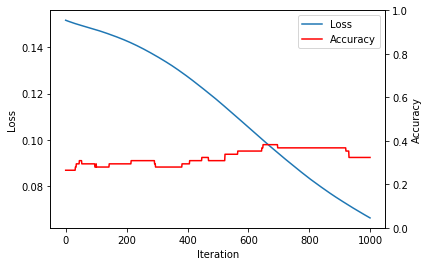

In [10]:
"""
Plot the train loss curve
"""
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(cost_history,label="Loss")
ax2 = ax.twinx()
lns2 = ax2.plot(accuracy_history,"-r",label="Accuracy")

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=0)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

plt.savefig(r"fig/iteration.pdf",format="pdf",dpi=200)
plt.show()